In [1]:
import random

import matplotlib.pyplot as plt
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, VerticalFlip, Crop, PixelDropout, CropAndPad, RandomBrightnessContrast
)
import config
import paths
import randomness
from cnn_builder import *
from config import *
from dataset_functions import *
from functools import partial
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import random
import randomness
import rendering
import training_history

import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2
%pylab inline

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['random', 'shuffle', 'copy', 'inf']
`%matplotlib` prevents importing * from pylab and numpy



2 Physical GPUs, 2 Logical GPUs


In [2]:
font_mapping = {'family': 'Palatino Linotype', 'weight': 'normal', 'size': 11}
plt.rc('font', **font_mapping)

In [3]:
hc_array_red, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf,
                                                 folder='media/Mateus_2022/red/')
hc_array_white, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf,
                                                   folder='media/Mateus_2022/white/', baseline_class_idx=max_class_idx)

hc_array = hc_array_red + hc_array_white
hc_set = HypercubeSet(hc_array)
hc_set.print_num_samples()

Reading media/Mateus_2022/red\raw_112_rf.hdr ...
Hypercube shape: (1872, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_1984_rf.hdr ...
Hypercube shape: (1920, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_3904_rf.hdr ...
Hypercube shape: (1840, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_5744_rf.hdr ...
Hypercube shape: (1840, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (

In [4]:
hc_set.identify_ground_samples()

In [5]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

In [6]:
hc_set.split_hypercubes(test_percentage=config.test_split)
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Train size: 123941, Test size: 21873
Train size: 131207, Test size: 23155
Train size: 101716, Test size: 17950
Train size: 94119, Test size: 16610
Train size: 9856, Test size: 1740
Train size: 58781, Test size: 10374
Train size: 143288, Test size: 25287
Train size: 68962, Test size: 12170
Train size: 192792, Test size: 34023
Train size: 76042, Test size: 13420
Train size: 193339, Test size: 34119
Train size: 54054, Test size: 9539
Train size: 94259, Test size: 16635
|████████████████████████████████████████| 52/52 [100%] in 4:09.5 (0.21/s)                                              


(FactorAnalysis(n_components=40, random_state=42), StandardScaler())

In [7]:
num_classes = hc_set.get_num_classes() - 1
img_shape = (config.patch_size, config.patch_size, config.num_target_features)
num_iterations = int(config.epochs / config.num_training_splits / config.num_transformation_iterations)
percentage_step = 1.0 / config.num_training_splits

In [8]:
# X_train_augmented = X_train.copy()
# augment_fn2 = X_train.copy()
#
# transform_array = [ HorizontalFlip(p=1), VerticalFlip(p=1) ]
# transform_array_title = [ "Horizontal Flip", "Vertical Flip" ]
# angle_diff = 90
# for i in range(-270, 360, angle_diff):
#     if i != 0:
#         transform_array.append(Rotate(limit=(i, i), p=1.0))
#         transform_array_title.append("Rotate " + str(i) + "º")
#
# # for i in range(len(X_train)):
# #     random_seed = np.random.randint(0, X_train.shape[0] * 10)
# #     randomness.set_seed(random_seed)
# #     X_train_augmented[i, :, :, 0] = transforms(image=X_train[i, :, :, 0])["image"]
# #     randomness.set_seed(random_seed)
# #     augment_fn2[i, :, :, 0] = transforms(image=X_train[i, :, :, 1])["image"]
# #
# # # Compute distance between augmented images
# # print(np.linalg.norm(X_train_augmented - augment_fn2))
#
# num_rows = 3
# num_cols = len(transform_array) + 1
# layer = 20
#
# fig = plt.figure(figsize=(num_cols * 1.7, num_rows * 1.7))
# for i in range(num_rows):
#     random_image_index = np.random.randint(0, X_train.shape[0])
#
#     for j in range(num_cols):
#         ax = fig.add_subplot(num_rows, num_cols, i * num_cols + j + 1, xticks=[], yticks=[])
#
#         if j == 0:
#             # Title
#             if i == 0:
#                 ax.set_title("Original")
#             ax.imshow(X_train[random_image_index, :, :, layer], cmap='gray')
#         else:
#             if i == 0:
#                 ax.set_title(transform_array_title[j - 1])
#             ax.imshow(transform_array[j - 1](image=X_train[random_image_index, :, :, layer])["image"], cmap='gray')
#
# plt.tight_layout()
# plt.savefig("transformations.png", dpi=500)
# plt.show()

In [9]:
# from keras.utils import Sequence
#
# class TransformedBatch(Sequence):
#     def __init__(self, x_set, y_set, batch_size, augmentations, validation_sequence, num_epochs, num_splits=5):
#         self.x, self.y = x_set, y_set
#         self.len_x = self.x.shape[0]
#         self.batch_size = batch_size
#         self.augment = augmentations
#         self.validation_sequence = validation_sequence
#         self.k_fold_indices = None
#         self.num_splits = num_splits
#         self.epoch = 0
#         self.k_fold_idx = 0
#         self.num_epochs = num_epochs
#
#         self.build_kfold()
#         self.train_indices, validation = self.get_kfold(self.k_fold_idx)
#         self.validation_sequence.set_validation_set(self.x[validation], self.y[validation])
#
#     def __len__(self):
#         return int(np.ceil(len(self.train_indices) / float(self.batch_size)))
#
#     def __getitem__(self, idx):
#         train_x, train_y = self.x[self.train_indices], self.y[self.train_indices]
#         batch_x = train_x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = train_y[idx * self.batch_size:(idx + 1) * self.batch_size]
#
#         for i in range(len(batch_x)):
#             for layer in range(batch_x.shape[-1]):
#                 randomness.set_seed(42)
#                 batch_x[i, :, :, layer] = self.augment(image=batch_x[i, :, :, layer])["image"]
#
#         return batch_x, batch_y
#
#     def __on_epoch_end__(self):
#         self.epoch += 1
#         new_k_fold_idx = self.epoch // (self.num_epochs // self.num_splits)
#
#         if new_k_fold_idx != self.k_fold_idx:
#             self.k_fold_idx = new_k_fold_idx
#             train, validation = self.get_kfold(self.k_fold_idx)
#             self.validation_sequence.set_validation_set(self.x[validation], self.y[validation])
#
#     def build_kfold(self):
#         # Get self.len_x random indices
#         self.k_fold_indices = np.random.permutation(self.len_x)
#
#     def get_kfold(self, idx):
#         print(idx)
#         k_fold_validation = self.k_fold_indices[idx * self.len_x // self.num_splits:(idx + 1) * self.len_x // self.num_splits]
#         k_fold_train = np.delete(self.k_fold_indices, k_fold_validation)
#
#         return k_fold_train, k_fold_validation
#
# class TransformedValidation(Sequence):
#     def __init__(self):
#         self.x, self.y = None, None
#
#     def __len__(self):
#         return int(len(self.x))
#
#     def __getitem__(self, idx):
#         return self.x, self.y
#
#     def set_validation_set(self, x, y):
#         self.x, self.y = x, y

In [13]:
transforms = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=(-360, -360), p=0.1),
    Rotate(limit=(-270, -270), p=0.1),
    Rotate(limit=(-180, -180), p=0.1),
    Rotate(limit=(-90, -90), p=0.1),
    Rotate(limit=(90, 90), p=0.1),
    Rotate(limit=(180, 180), p=0.1),
    Rotate(limit=(270, 270), p=0.1)
])

model = build_network(network_type=network_type, num_classes=num_classes, image_dim=img_shape)
compile_network(model, network_type, network_name, num_classes, show_summary=True, render_image=True)
model.save_weights(network_name + "_init.h5")

{'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x000001A23C886370>, 'callbacks': [], 'intermediate_activation': 'relu', 'kernel_size': 3, 'start_size': 16, 'strides': 2}
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 23, 23, 40)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape_2 (Reshape)            (None, 529, 40)      0           ['input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 529, 40)      0           ['reshape_2[0][0]']            

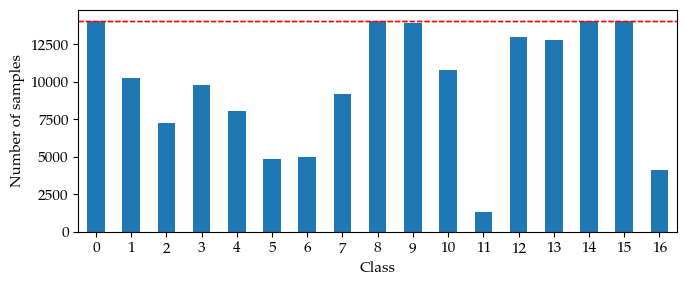

Training for 22 epochs with batch size of 1024...
Epoch 1/22
147/147 [==============================] - ETA: 0s - loss: 2.2227 - sparse_categorical_accuracy: 0.2774
Epoch 1: val_loss improved from inf to 2.18568, saving model to results/uav/network\allopezr_2d_23x22_16_0.h5
147/147 [==============================] - 15s 80ms/step - loss: 2.2227 - sparse_categorical_accuracy: 0.2774 - val_loss: 2.1857 - val_sparse_categorical_accuracy: 0.3967
Epoch 2/22
146/147 [============================>.] - ETA: 0s - loss: 1.4003 - sparse_categorical_accuracy: 0.4969
Epoch 2: val_loss improved from 2.18568 to 1.31770, saving model to results/uav/network\allopezr_2d_23x22_16_0.h5
147/147 [==============================] - 10s 71ms/step - loss: 1.3998 - sparse_categorical_accuracy: 0.4970 - val_loss: 1.3177 - val_sparse_categorical_accuracy: 0.5579
Epoch 3/22
146/147 [============================>.] - ETA: 0s - loss: 1.1042 - sparse_categorical_accuracy: 0.5955
Epoch 3: val_loss improved from 1.31770

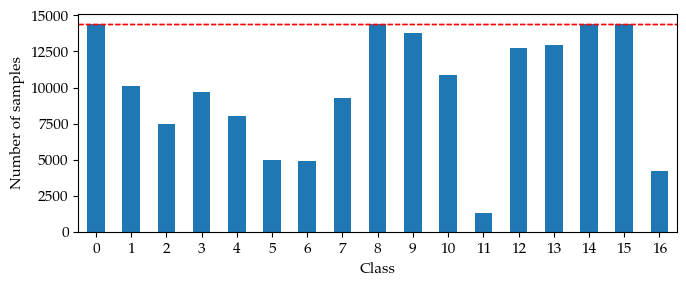

Training for 22 epochs with batch size of 1024...
Epoch 1/22
148/148 [==============================] - ETA: 0s - loss: 0.2077 - sparse_categorical_accuracy: 0.9253
Epoch 1: val_loss did not improve from 0.16205
148/148 [==============================] - 12s 78ms/step - loss: 0.2077 - sparse_categorical_accuracy: 0.9253 - val_loss: 0.1705 - val_sparse_categorical_accuracy: 0.9356
Epoch 2/22
147/148 [============================>.] - ETA: 0s - loss: 0.1921 - sparse_categorical_accuracy: 0.9305
Epoch 2: val_loss improved from 0.16205 to 0.14883, saving model to results/uav/network\allopezr_2d_23x22_16_0.h5
148/148 [==============================] - 10s 70ms/step - loss: 0.1922 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.1488 - val_sparse_categorical_accuracy: 0.9459
Epoch 3/22
147/148 [============================>.] - ETA: 0s - loss: 0.1805 - sparse_categorical_accuracy: 0.9342
Epoch 3: val_loss improved from 0.14883 to 0.13871, saving model to results/uav/network\allopezr_2d_23

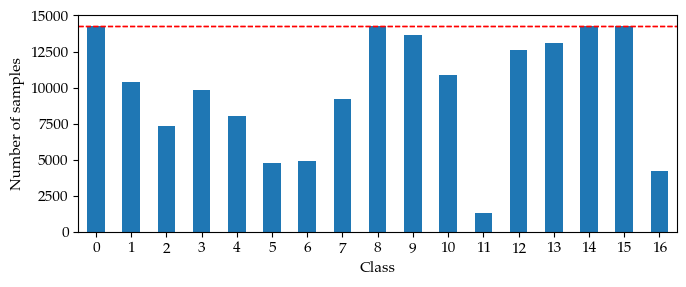

Training for 22 epochs with batch size of 1024...
Epoch 1/22
147/147 [==============================] - ETA: 0s - loss: 0.1308 - sparse_categorical_accuracy: 0.9553
Epoch 1: val_loss did not improve from 0.08830
147/147 [==============================] - 12s 79ms/step - loss: 0.1308 - sparse_categorical_accuracy: 0.9553 - val_loss: 0.0908 - val_sparse_categorical_accuracy: 0.9684
Epoch 2/22
147/147 [==============================] - ETA: 0s - loss: 0.1191 - sparse_categorical_accuracy: 0.9580
Epoch 2: val_loss improved from 0.08830 to 0.08701, saving model to results/uav/network\allopezr_2d_23x22_16_0.h5
147/147 [==============================] - 10s 70ms/step - loss: 0.1191 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.0870 - val_sparse_categorical_accuracy: 0.9692
Epoch 3/22
147/147 [==============================] - ETA: 0s - loss: 0.1126 - sparse_categorical_accuracy: 0.9598
Epoch 3: val_loss improved from 0.08701 to 0.07897, saving model to results/uav/network\allopezr_2d_23

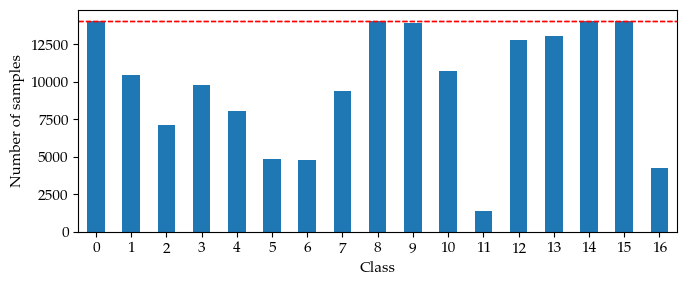

Training for 22 epochs with batch size of 1024...
Epoch 1/22
147/147 [==============================] - ETA: 0s - loss: 0.0966 - sparse_categorical_accuracy: 0.9680
Epoch 1: val_loss did not improve from 0.06065
147/147 [==============================] - 13s 84ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.0611 - val_sparse_categorical_accuracy: 0.9782
Epoch 2/22
146/147 [============================>.] - ETA: 0s - loss: 0.0877 - sparse_categorical_accuracy: 0.9695
Epoch 2: val_loss improved from 0.06065 to 0.05845, saving model to results/uav/network\allopezr_2d_23x22_16_0.h5
147/147 [==============================] - 11s 74ms/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.0584 - val_sparse_categorical_accuracy: 0.9794
Epoch 3/22
146/147 [============================>.] - ETA: 0s - loss: 0.0824 - sparse_categorical_accuracy: 0.9711
Epoch 3: val_loss improved from 0.05845 to 0.05391, saving model to results/uav/network\allopezr_2d_23

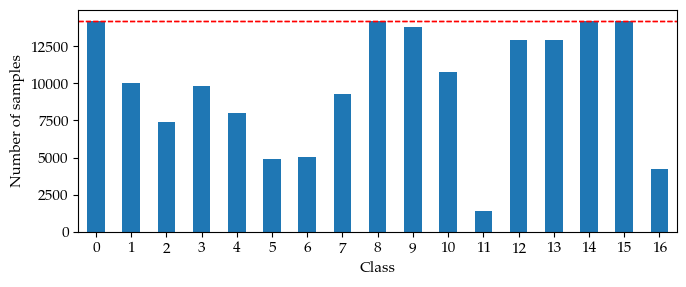

Training for 22 epochs with batch size of 1024...
Epoch 1/22
147/147 [==============================] - ETA: 0s - loss: 0.0799 - sparse_categorical_accuracy: 0.9736
Epoch 1: val_loss did not improve from 0.04222
147/147 [==============================] - 12s 80ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.0526 - val_sparse_categorical_accuracy: 0.9808
Epoch 2/22
147/147 [==============================] - ETA: 0s - loss: 0.0708 - sparse_categorical_accuracy: 0.9757
Epoch 2: val_loss did not improve from 0.04222
147/147 [==============================] - 10s 71ms/step - loss: 0.0708 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.0440 - val_sparse_categorical_accuracy: 0.9842
Epoch 3/22
147/147 [==============================] - ETA: 0s - loss: 0.0665 - sparse_categorical_accuracy: 0.9772
Epoch 3: val_loss improved from 0.04222 to 0.03926, saving model to results/uav/network\allopezr_2d_23x22_16_0.h5
147/147 [==============================] - 10s 71ms/ste

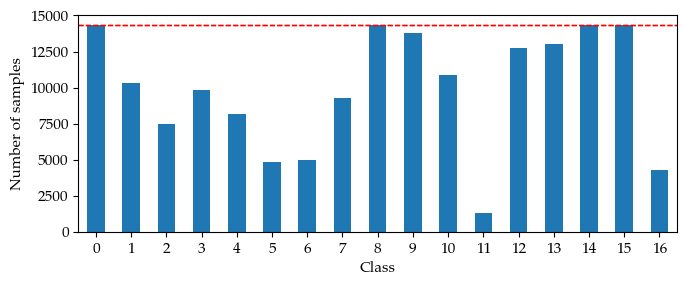

Training for 22 epochs with batch size of 1024...
Epoch 1/22
148/148 [==============================] - ETA: 0s - loss: 0.0656 - sparse_categorical_accuracy: 0.9789
Epoch 1: val_loss did not improve from 0.03653
148/148 [==============================] - 12s 78ms/step - loss: 0.0656 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0374 - val_sparse_categorical_accuracy: 0.9873
Epoch 2/22
147/148 [============================>.] - ETA: 0s - loss: 0.0599 - sparse_categorical_accuracy: 0.9801
Epoch 2: val_loss improved from 0.03653 to 0.03297, saving model to results/uav/network\allopezr_2d_23x22_16_0.h5
148/148 [==============================] - 10s 70ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.0330 - val_sparse_categorical_accuracy: 0.9883
Epoch 3/22
147/148 [============================>.] - ETA: 0s - loss: 0.0544 - sparse_categorical_accuracy: 0.9813
Epoch 3: val_loss did not improve from 0.03297
148/148 [==============================] - 10s 69ms/ste

In [14]:
import gc

history = training_history.TrainingHistory(accuracy_name='sparse_categorical_accuracy')
callbacks, time_callback = get_callback_list(model_name=network_name)

### Training
for batch in range(config.num_training_splits):
    X_train, y_train = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping, train=True,
                                    start_percentage=percentage_step * batch, end_percentage=percentage_step * (batch + 1))
    X_train, y_train = randomness.stratified_sampling(X_train, y_train, use_float=True, num_reduced_classes=3)
    render_mask_histogram(y_train)

    for it in range(config.num_transformation_iterations):
        X_train_transformed = X_train.copy()

        for i in range(len(X_train_transformed)):
            random_seed = np.random.randint(0, X_train_transformed.shape[0] * 10)
            for layer in range(X_train_transformed.shape[-1]):
                randomness.set_seed(random_seed)
                X_train_transformed[i, :, :, layer] = transforms(image=X_train_transformed[i, :, :, layer])["image"]

        X_train_it, X_validation_it, y_train_it, y_validation_it = split_train_test(X_train_transformed, y_train, test_size=config.validation_split * (1.0 - config.test_split), random_seed=randomness.random_seed)

        del X_train_transformed
        gc.collect()

        history.append_history(run_model(model, X_train_it, y_train_it, X_validation_it, y_validation_it, callbacks=callbacks, num_epochs=num_iterations).history, time_callback)

        del X_train_it, X_validation_it, y_train_it, y_validation_it
        gc.collect()

    del X_train, y_train
    gc.collect()

1173/1173 [==============================] - 12s 10ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9885
Test Loss: 0.03625987842679024, Test Accuracy: 0.9885433912277222
1175/1175 [==============================] - 12s 10ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9878
Test Loss: 0.03950464725494385, Test Accuracy: 0.9877561926841736
1171/1171 [==============================] - 11s 10ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9882
Test Loss: 0.038325946778059006, Test Accuracy: 0.9881712198257446


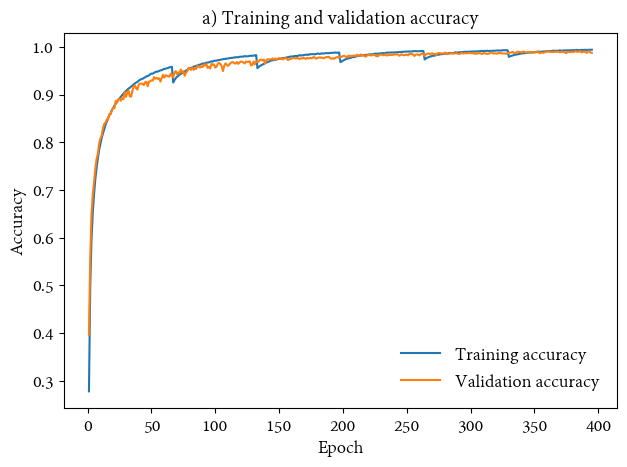

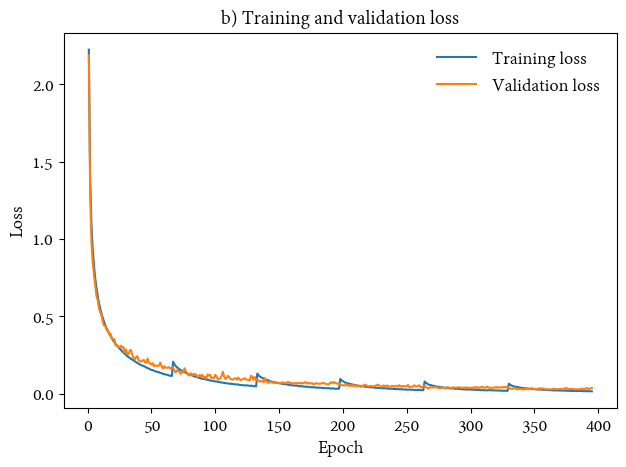

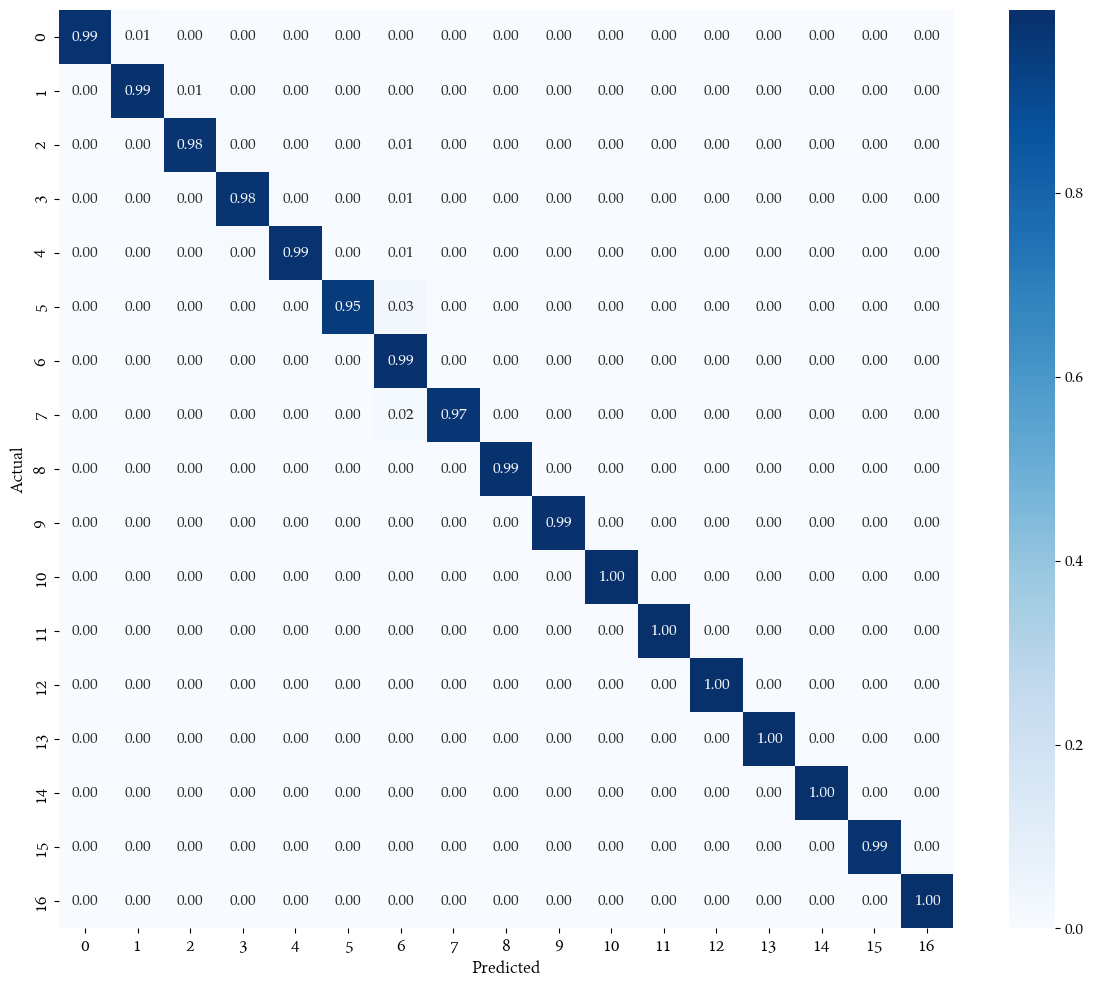

In [15]:
#### Split test into batches
y_test_global = []
test_prediction_global = []
test_prediction_prob_global = []

for batch in range(config.num_test_splits):
    X_test, y_test = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping,
                                  train=False, start_percentage=percentage_step * batch,
                                  end_percentage=percentage_step * (batch + 1))
    test_prediction_prob = model.predict(X_test)
    test_prediction = np.argmax(test_prediction_prob, axis=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

    # y test to int
    y_test_global.extend(np.asarray(y_test, dtype="int64").tolist())
    test_prediction_global.extend(test_prediction.tolist())
    test_prediction_prob_global.extend(test_prediction_prob.tolist())

    del X_test, y_test, test_prediction, test_prediction_prob
    gc.collect()

y_test_global = np.asarray(y_test_global)
test_prediction_global = np.asarray(test_prediction_global)
test_prediction_prob_global = np.asarray(test_prediction_prob_global)

# Graphic results
render_model_history(history, model_name=network_name)
render_confusion_matrix(y_test_global, test_prediction_global, model_name=network_name)